In [23]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Simulating price impacts of different order sizes

This notebook contains simlations of how different order sizes impact premium price in pools of different size. 

## Table of Contents:
* [Deploying contracts](#Deploying-contracts)
* [Generating data](#Generating-data)
* [Plots](#Plots)



There were some changes done to the AMM itself, which won't be included in the commit, but can be easily reproducible:

 - hardcoded ETH price of 1.2k
     - changed value of underlying_price in amm.cairo
 - changed init_pool function in initialize_amm.cairo
     - changed name to init_pool_dummy and it now takes an initial pool size number as an input
 -  hardcoded current block time in _time_till_maturity
     - changed curr_time in amm.cairo to 1640991600 -> 31/12/2021 

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import pandas as pd

from starkware.starknet.testing.starknet import Starknet
from starkware.starknet.testing.contract import StarknetContract
from starkware.starkware_utils.error_handling import StarkException

from aux import (
    USER_ID,
    STARTING_TOKEN_BALANCE_1,
    STARTING_TOKEN_BALANCE_2,
    STRIKE_PRICE,
    CURRENT_PRICE,
    CURRENT_PRICE_2,
    do_trade,
    pretty_dict,
    show_current_premium
)


### Deploying contracts

In [4]:
net = await Starknet.empty()

In [9]:
async def deploy_and_add_tokens(pool_size):
    mm = await net.deploy(source = os.path.join('..', '..', 'contracts/main.cairo'), 
    cairo_path = ['../..', 
                 '../../lib/cairo_math_64x61/contracts/cairo_math_64x61',
                 '../../contracts']) # fuk them imports
    await mm.init_pool_dummy(pool_size).invoke()

    await mm.add_fake_tokens(
        account_id=USER_ID,
        amount_token_a=STARTING_TOKEN_BALANCE_1,
        amount_token_b=STARTING_TOKEN_BALANCE_2).invoke()
    return mm

In [10]:
# Define pool and order sizes to test

pool_sizes = [20_000, 35_000, 50_000, 75_000, 100_000, 150_000]
order_sizes = [1, 5, 7, 10, 13, 15, 17, 20, 25, 40, 50, 75, 90, 100, 150]

In [12]:
# Deploy contracts and store them in dict for easier iteration

data = {
    k : {
        'func': await deploy_and_add_tokens(k)
    } for k in pool_sizes
}

### Generating data

In [28]:
for key in data.keys():
    data[key]['records'] = []
    print(f'Working on amm with pool size: {key:_}')
    
    for order_size in order_sizes:
        try: 
            tmp = {}
            tmp['order_size'] = order_size
            print(f'  Current order size: {order_size}')
            
            # Retrieve premium before trades
            tmp.update({f'init_{k}': value for k, value in (await show_current_premium(data[key]['func'], 1, True)).items()})

            # Conduct trades
            await do_trade(data[key]['func'], order_size * 2**61, 0, 0)
            await do_trade(data[key]['func'], order_size * 2**61, 1, 0)

            # Retrieve premium after trades
            tmp.update({f'after_{k}': value for k, value in (await show_current_premium(data[key]['func'], 1, True)).items()})

            # Calculate changes in premium
            tmp['premium_change_CALL'] = tmp['after_prem_CALL'] - tmp['init_prem_CALL']
            tmp['premium_change_PUT'] = tmp['after_prem_PUT'] - tmp['init_prem_PUT']

            tmp['perc_premium_change_CALL'] =  (tmp['after_prem_CALL'] / tmp['init_prem_CALL'] - 1) * 100
            tmp['perc_premium_change_PUT'] = (tmp['after_prem_PUT'] / tmp['init_prem_PUT'] - 1) * 100


            data[key]['records'].append(tmp)

            # Reset the pools for the next order size simulation
            data[key]['func'] = await deploy_and_add_tokens(key)
            
        except StarkException:
            print(f"  ERROR at order_size: {order_size:_}")
            continue

**Errors indicate places where there wasnt enough funds in the pool.**

In [14]:
# Remove Starknet Contracts from data because it's not serializable for pickle

for key in data.keys():
    del data[key]['func']

In [16]:
# Generating data can take quite a while, so it's provided in a pickle file
# with open('data_current_1200.pickle', 'wb') as f:
#     pickle.dump(data, f)

# with open('data_current_1200.pickle', 'rb') as f:
#     data = pickle.load(f)

<!-- Little easter egg :) -->

### Plots

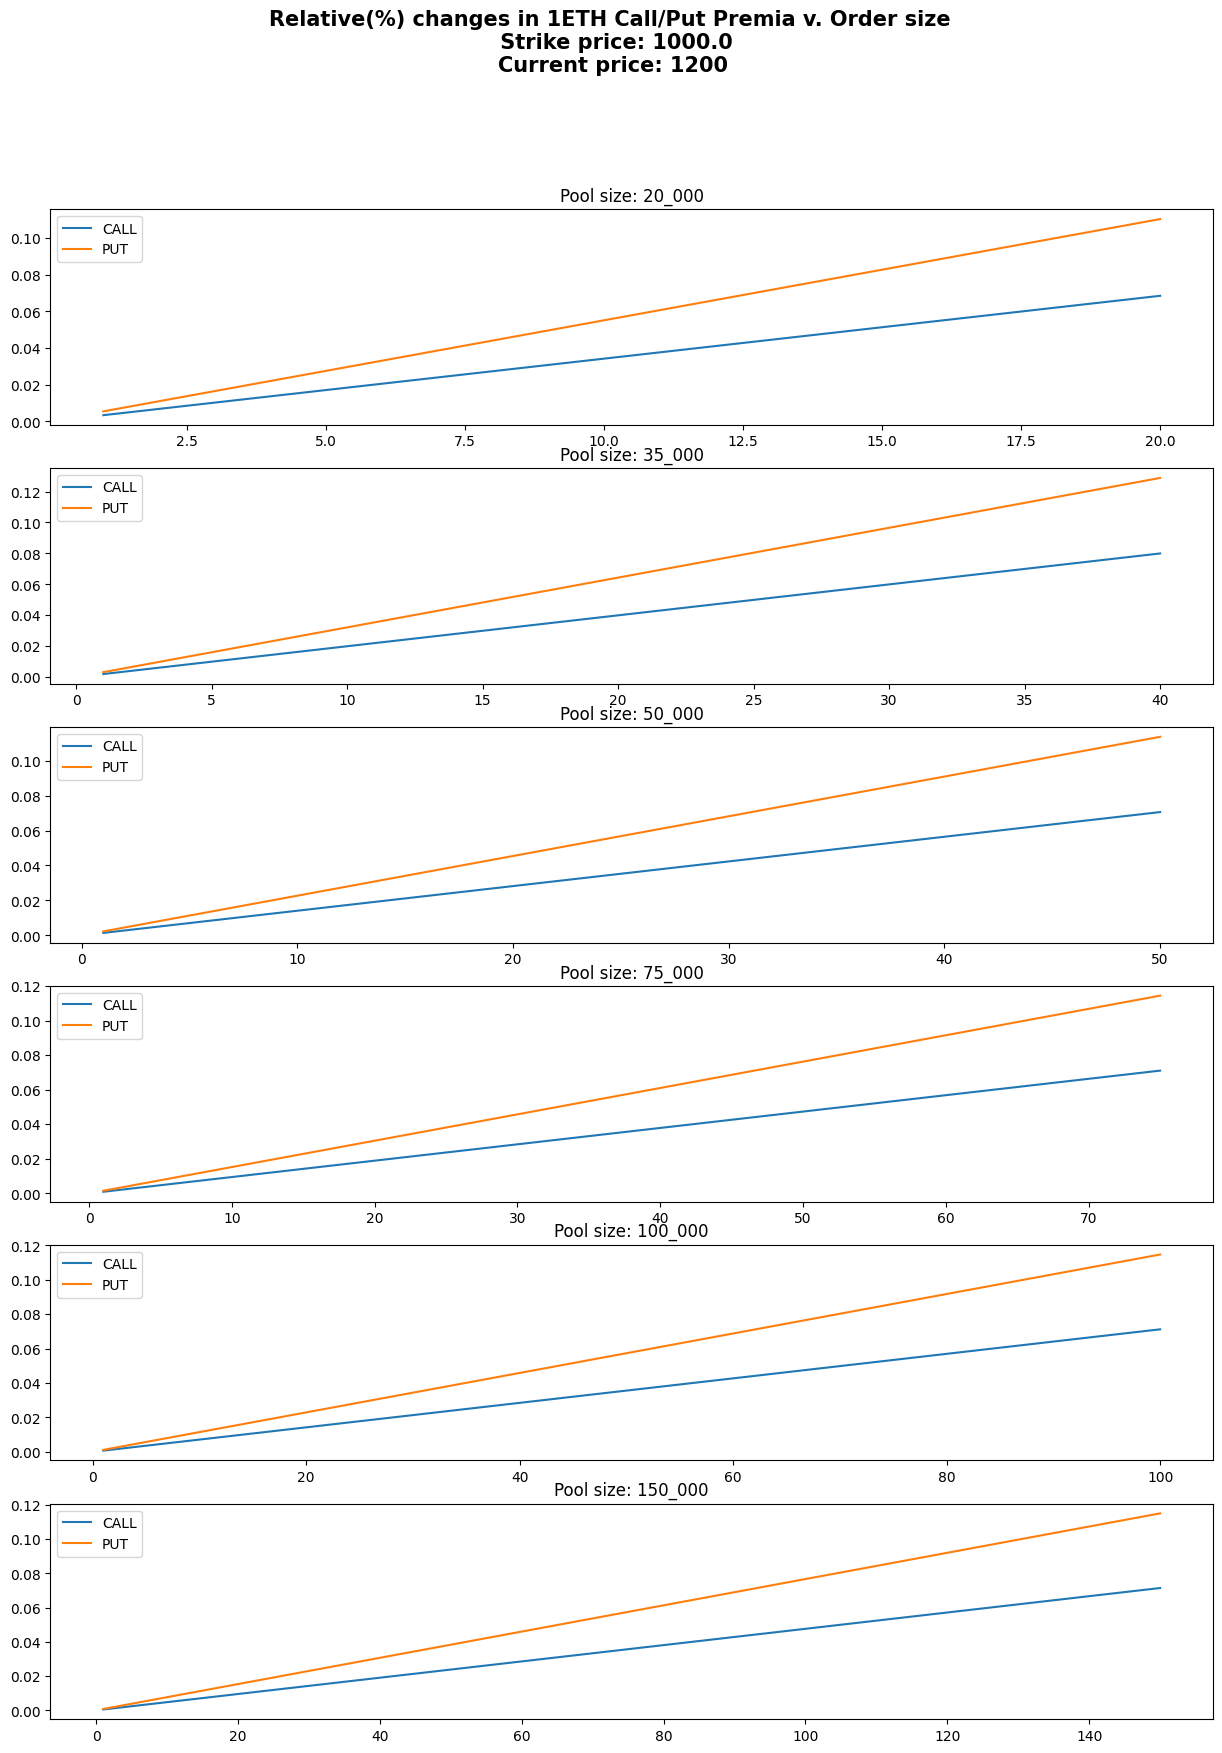

In [108]:
fig, ax = plt.subplots(ncols = 1, nrows = len(data.keys()))
fig.set_dpi(100)
fig.set_size_inches(15, 20)
fig.suptitle(f"Relative(%) changes in 1ETH Call/Put Premia v. Order size \n Strike price: {STRIKE_PRICE / 2**61}\nCurrent price: {CURRENT_PRICE}", fontweight="bold",  size=15)

for ix, (key, value) in enumerate(data.items()):
    tmp = pd.DataFrame(value['records'])
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_CALL'], label = 'CALL')
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_PUT'], label = 'PUT')
    ax[ix].legend()
    ax[ix].set_title(f'Pool size: {key:_}')

Whole process is repeated, but now with hardcoded ETH price of $800.

In [17]:
# File containing data for sims with current price = 800 named data_current_800.pickle

# with open('data_current_800.pickle', 'rb') as f:
#     data_2 = pickle.load(f)

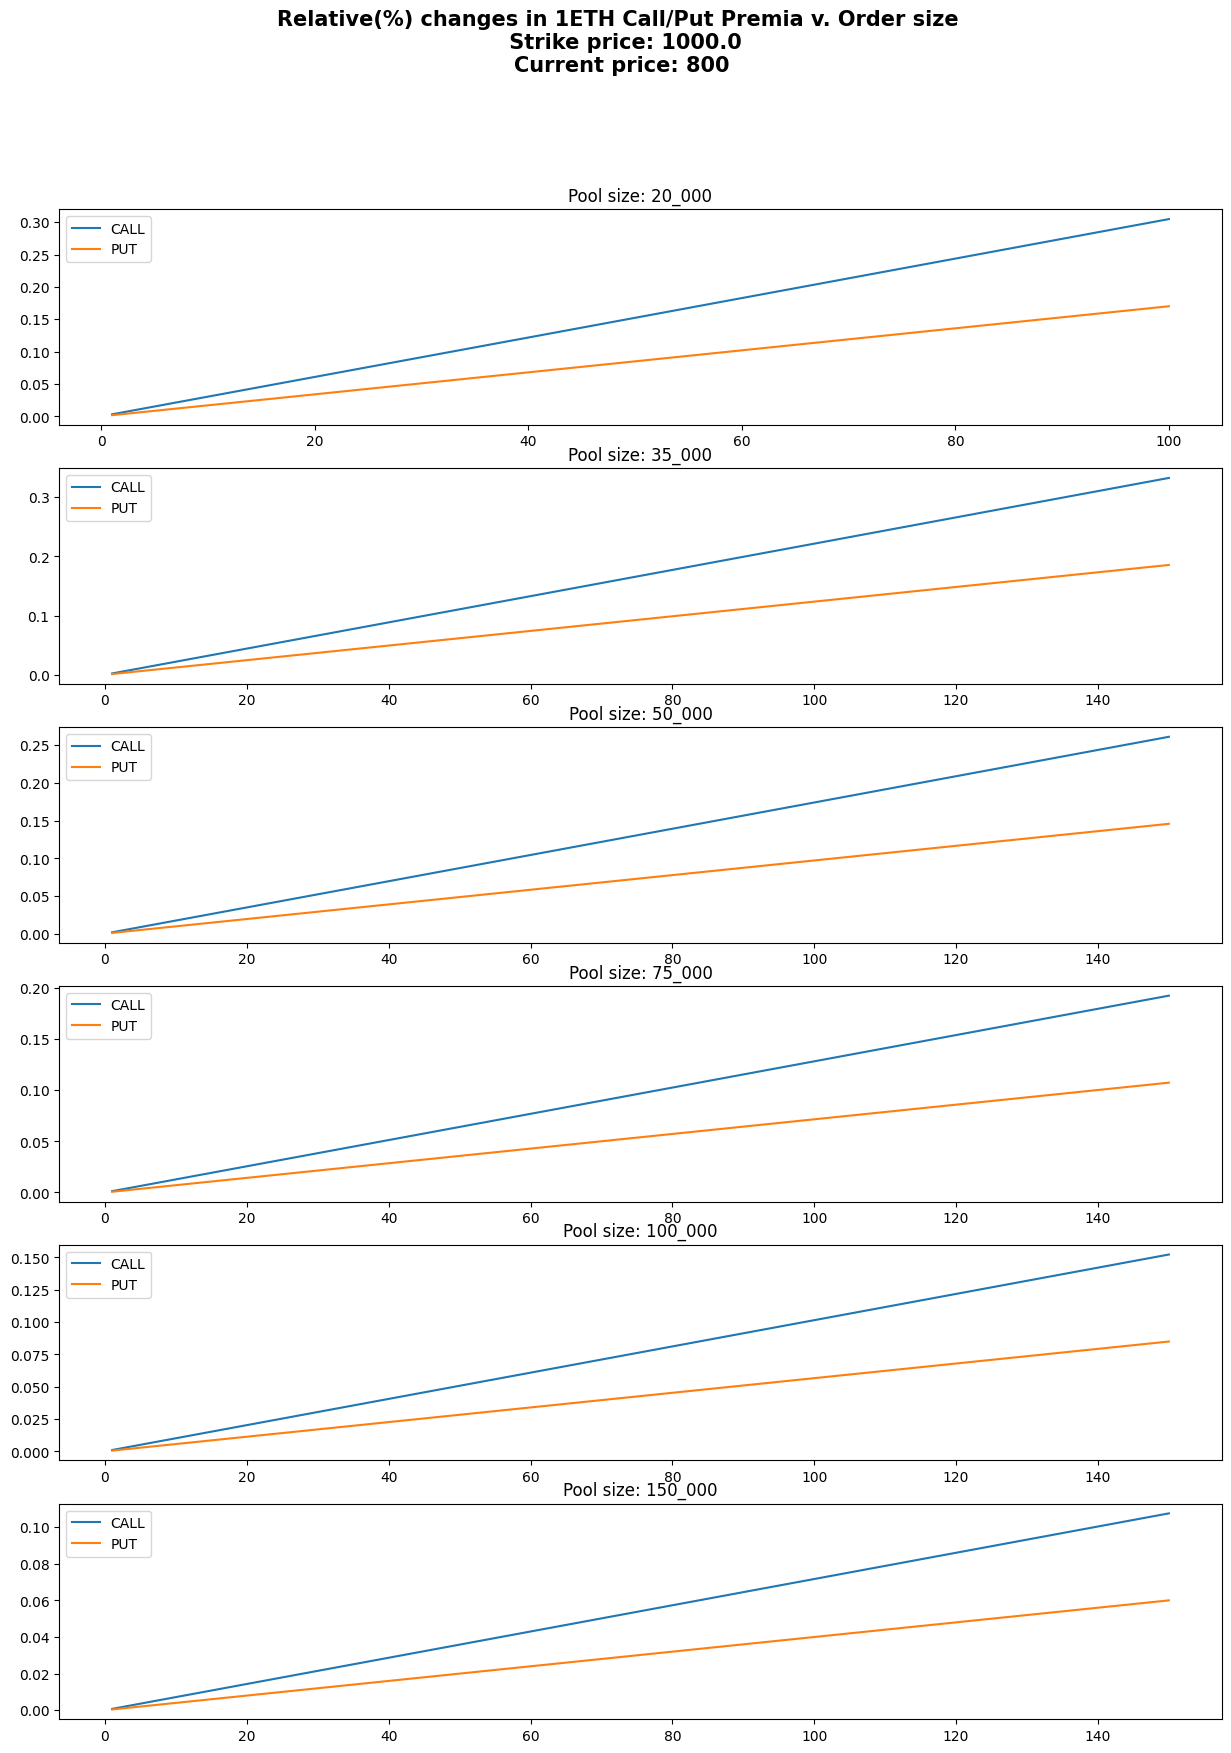

In [29]:
fig, ax = plt.subplots(ncols = 1, nrows = len(data_2.keys()))
fig.set_dpi(100)
fig.set_size_inches(15, 20)
fig.suptitle(f"Relative(%) changes in 1ETH Call/Put Premia v. Order size \n Strike price: {STRIKE_PRICE / 2**61}\nCurrent price: {CURRENT_PRICE_2}", fontweight="bold",  size=15)

for ix, (key, value) in enumerate(data_2.items()):
    tmp = pd.DataFrame(value['records'])
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_CALL'], label = 'CALL')
    ax[ix].plot(tmp['order_size'], tmp['perc_premium_change_PUT'], label = 'PUT')
    ax[ix].legend()
    ax[ix].set_title(f'Pool size: {key:_}')